In [1]:
import numba
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from skimage.measure import EllipseModel


import ztfidr
import galaxy_phot as glp

warnings.filterwarnings('ignore')

In [2]:
importlib.reload(glp)
sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

In [3]:
sn_len = 'ZTF19acihlft' # lenticular
sn_ell = 'ZTF18aalurka' # elliptical
sn_spi = 'ZTF18aahjaxz' # spiral

g_len = glp.HostGal(verbose=True)
g_len.init_dr2(sn_len, sample, host_data)
g_len.get_image(source='save', survey='auto', output_='z', band='g', scale=0.262)

g_ell = glp.HostGal(verbose=True)
g_ell.init_dr2(sn_ell, sample, host_data)
g_ell.get_image(source='save', survey='auto', output_='z', band='g', scale=0.262)

g_spi = glp.HostGal(verbose=True)
g_spi.init_dr2(sn_spi, sample, host_data)
g_spi.get_image(source='save', survey='auto', output_='z', band='g', scale=0.262)

ZTF19acihlft 325.97262 -10.183639999999999 0.02
legacy 700 0.262
ZTF18aalurka 150.77958999999998 -15.476120000000002 0.028773000000000003
legacy 483 0.262
ZTF18aahjaxz 193.45251000000002 29.58837 0.04630438
legacy 296 0.262


In [4]:
@numba.njit()
def feature_removal(data, size, width, dim):
    for i in range(0, dim, width*2):
        for j in range(0, dim, width*2):
            if (dim/2-i)**2 + (dim/2-j)**2 < (size*1.5)**2:
                continue
            vec = data - np.array([i, j])
            dists = np.sqrt(vec.T[0]**2 + vec.T[1]**2)
            px_center = np.sum(dists < size)
            px_edge = np.sum((dists > size) & (dists <= size+width))
            if (px_center > 0) and (px_edge == 0):
                data = data[dists > size]
    return data

def chop_boundary(data, size, depth):
    cond1 = ~np.isin(data.T[0], list(range(depth)))
    cond2 = ~np.isin(data.T[1], list(range(depth)))
    cond3 = ~np.isin(data.T[0],list(range(size-depth, size)))
    cond4 = ~np.isin(data.T[1],list(range(size-depth, size)))
    return data[cond1 & cond2 & cond3 & cond4]

def run_fit(window, isophote, gobj):
    mag = gobj.cutout['mag']

    gauss = np.array([  [ 1,  4,  7,  4,  1],
                    [ 4, 16, 26, 16,  4],
                    [ 7, 26, 41, 26,  7],
                    [ 4, 16, 26, 16,  4],
                    [ 1,  4,  7,  4,  1]]) * 1/273
    
    kernal = np.array([ [ 0,  0,  1,  1,  1],
                    [ 0,  0,  0,  1,  1],
                    [-1,  0,  0,  0,  1],
                    [-1, -1,  0,  0,  0],
                    [-1, -1, -1,  0,  0]])

    kernal_a = 1/(kernal + isophote)
    kernal_ = kernal_a / np.sum(kernal_a)
    
    conv_blur = convolve2d(mag, gauss, mode='same')
    conv1 = convolve2d(conv_blur, kernal_, mode='same')
    conv2 = convolve2d(conv1, kernal_[::-1], mode='same')
    

    contour = np.stack(np.where((conv2.T > isophote-window) & (conv2.T < isophote+window)))
    contour = contour.T[::max(len(contour.T)//3000, 1)]
    contour_r = chop_boundary(contour, len(mag), 5)
    
    noise = np.zeros(len(contour_r))
    for i in range(len(contour_r)):
        dists = np.linalg.norm(contour_r[i]-contour_r, axis=1)
        dists.sort()
        noise[i] = dists[1:8].mean()
    contour_r = contour_r[noise < 10]

    contour_small = feature_removal(contour_r, 50, 5, len(mag)) 
    contour_medium = feature_removal(contour_small, 150, 5, len(mag)) 
    
    px_fit = contour_medium.copy()
    if len(px_fit) >= 30:
        ell = EllipseModel()
        ell.estimate(px_fit)
        res = ell.residuals(px_fit)
        return ell.params, np.sum(res**2)/len(res), contour, contour_r, px_fit
    else:
        return (0, 0, 0, 0, 0), 1000, [], [], []

In [6]:
mag_r = np.arange(20, 25, 0.1)
c_r_len = np.zeros((len(mag_r), 6))
c_r_ell = np.zeros((len(mag_r), 6))
c_r_spi = np.zeros((len(mag_r), 6))
for i, iso_i in enumerate(mag_r):
    (xc, yc, a, b, theta), res, px_all, px_red, px_fit = run_fit(0.4, iso_i, g_len)
    c_r_len[i] = [xc, yc, a, b, theta, res]

    (xc, yc, a, b, theta), res, px_all, px_red, px_fit = run_fit(0.4, iso_i, g_ell)
    c_r_ell[i] = [xc, yc, a, b, theta, res]

    (xc, yc, a, b, theta), res, px_all, px_red, px_fit = run_fit(0.4, iso_i, g_spi)
    c_r_spi[i] = [xc, yc, a, b, theta, res]


In [19]:
def ellipse_para(theta, xc, yc, a, b, pa):
    x = a*np.cos(theta)*np.cos(pa) - b*np.sin(theta)*np.sin(pa) + xc
    y = a*np.cos(theta)*np.sin(pa) + b*np.sin(theta)*np.cos(pa) + yc
    return x, y

def target_angle(ang, c_r):
    theta_ref = c_r[-1][4]
    target_ang = np.zeros(len(c_r))
    for i, row_i in enumerate(c_r):
        xci, yci, ai, bi, thetai, resi = row_i
        ep = ellipse_para(ang + (theta_ref - thetai),  xci, yci, ai, bi, thetai)
        target_ang[i] = np.sqrt((ep[0]-xci)**2 + (ep[1]-yci)**2)
    return target_ang * 0.262

targ_len = target_angle(0, c_r_len)
targ_ell = target_angle(0, c_r_ell)
targ_spi = target_angle(-np.pi/2, c_r_spi)

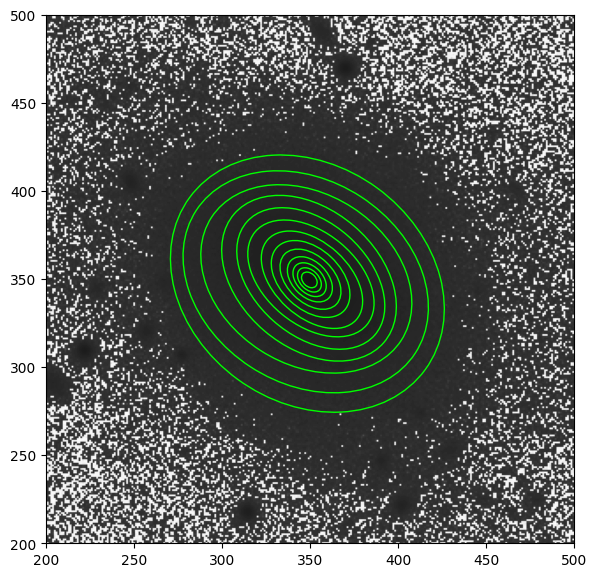

In [20]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
map_ = ax.imshow(g_len.cutout['mag'], cmap='gray')
ax.set_xlim([200, 500])
ax.set_ylim([200, 500])
for row_i in c_r_len[::-4]:
    xci, yci, ai, bi, thetai, resi = row_i
    ell_patchi = Ellipse((xci, yci), 2*ai, 2*bi, np.rad2deg(thetai), edgecolor='lime', facecolor='none', lw=1)
    ax.add_patch(ell_patchi)

In [21]:
t_code = {'Tr': -8, 'dSph': -7, 'E': -5, 'S0-': -3, 'S0': -2, 'S0+':-1, 'S0a': 0, 'Sa': 1, 
          'Sab': 2, 'Sb': 3, 'Sbc': 4, 'Sc': 5, 'Scd': 6, 'Sd': 7, 'Sdm': 8, 'Sm': 9, 'Ir': 10}

$\sin(i)^2 = \frac{1 - 10^{-2\log(r_{25})}}{1 - 10^{-2\log(r_{0})}}$

$\log(r_0) = 0.43 + 0.053 t$   [$t=-5...7$]

$\log(r_0) = 0.38$,  [$t > 7$]

$r_{25} = a/b$

Bulge:   $I_r = I_0 \exp\left((\frac{r}{h})^{1/n}\right)$, n=4 (de Vaucouleurs)

Disk:   $I_r = I_0 \exp\left(\frac{r}{h}\right)$

$\mu_r = \mu_0 - 2.5 \log_{10}(I)$

$\mu_{sum} = -2.5log_{10}(10^{-0.4\mu_{buldge}} + 10^{-0.4\mu_{disk}})$

In [44]:
def bulge(x, a, h, n):
    return a + 2.5*(x/h)**(1/n)

def disk(x, a, h):
    return a + 2.5*(x/h)

def add_mag(m1, m2):
    return -2.5*np.log10(10**(-0.4*m1) + 10**(-0.4*m2))

def combine(x, a_b, a_d, h_b, h_d, n):
    return add_mag(bulge(x, a_b, h_b, 4), disk(x, a_d, h_d))

cuts = mag_r < 24.5
out_len = curve_fit(combine, targ_len[cuts], mag_r[cuts], p0=[19, 20, 30, 30, 4])
out_ell = curve_fit(combine, targ_ell[cuts], mag_r[cuts], p0=[19, 20, 30, 30, 4])
out_spi = curve_fit(combine, targ_spi[cuts], mag_r[cuts], p0=[19, 20, 30, 30, 4])

In [45]:
def plot_lc(targ, out, ax, label):
    x_ax = np.linspace(1, np.max(targ), 100)
    ax.plot(targ, mag_r, 'k.',label=label)
    ax.plot(targ[~cuts], mag_r[~cuts], 'r.',label=label, marker='x', c='lime')
    ax.plot(x_ax, combine(x_ax, *out[0]), 'r--', label='combined')
    a_b, a_d, h_b, h_d, n = out[0]
    ax.plot(x_ax, bulge(x_ax, a_b, h_b, n), 'g--', label='bulge')
    ax.plot(x_ax, disk(x_ax, a_d, h_d), 'b--', label='disk')

    ax.set_ylim([18, 25.5])
    ax.invert_yaxis()
    ax.legend(fontsize=12)
    ax.set_xlabel('R [kpc]', fontsize=12)
    ax.set_ylabel('$\mu \:[mag\:arcsec^{-1}]$', fontsize=12)

def plot_contours(c_r, gobj, lims, ax, ang):
    ax.imshow(gobj.cutout['mag'], cmap='gray')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    theta_ref = c_r[-1][4]
    for row_i in c_r[::-4]:
        xci, yci, ai, bi, thetai, resi = row_i
        ep1 = ellipse_para(ang + (theta_ref - thetai),  xci, yci, ai, bi, thetai)
        ax.scatter(ep1[0], ep1[1], color='blue', s=20, zorder=10)

        ell_patchi = Ellipse((xci, yci), 2*ai, 2*bi, np.rad2deg(thetai), edgecolor='lime', facecolor='none', lw=1)
        ax.add_patch(ell_patchi)

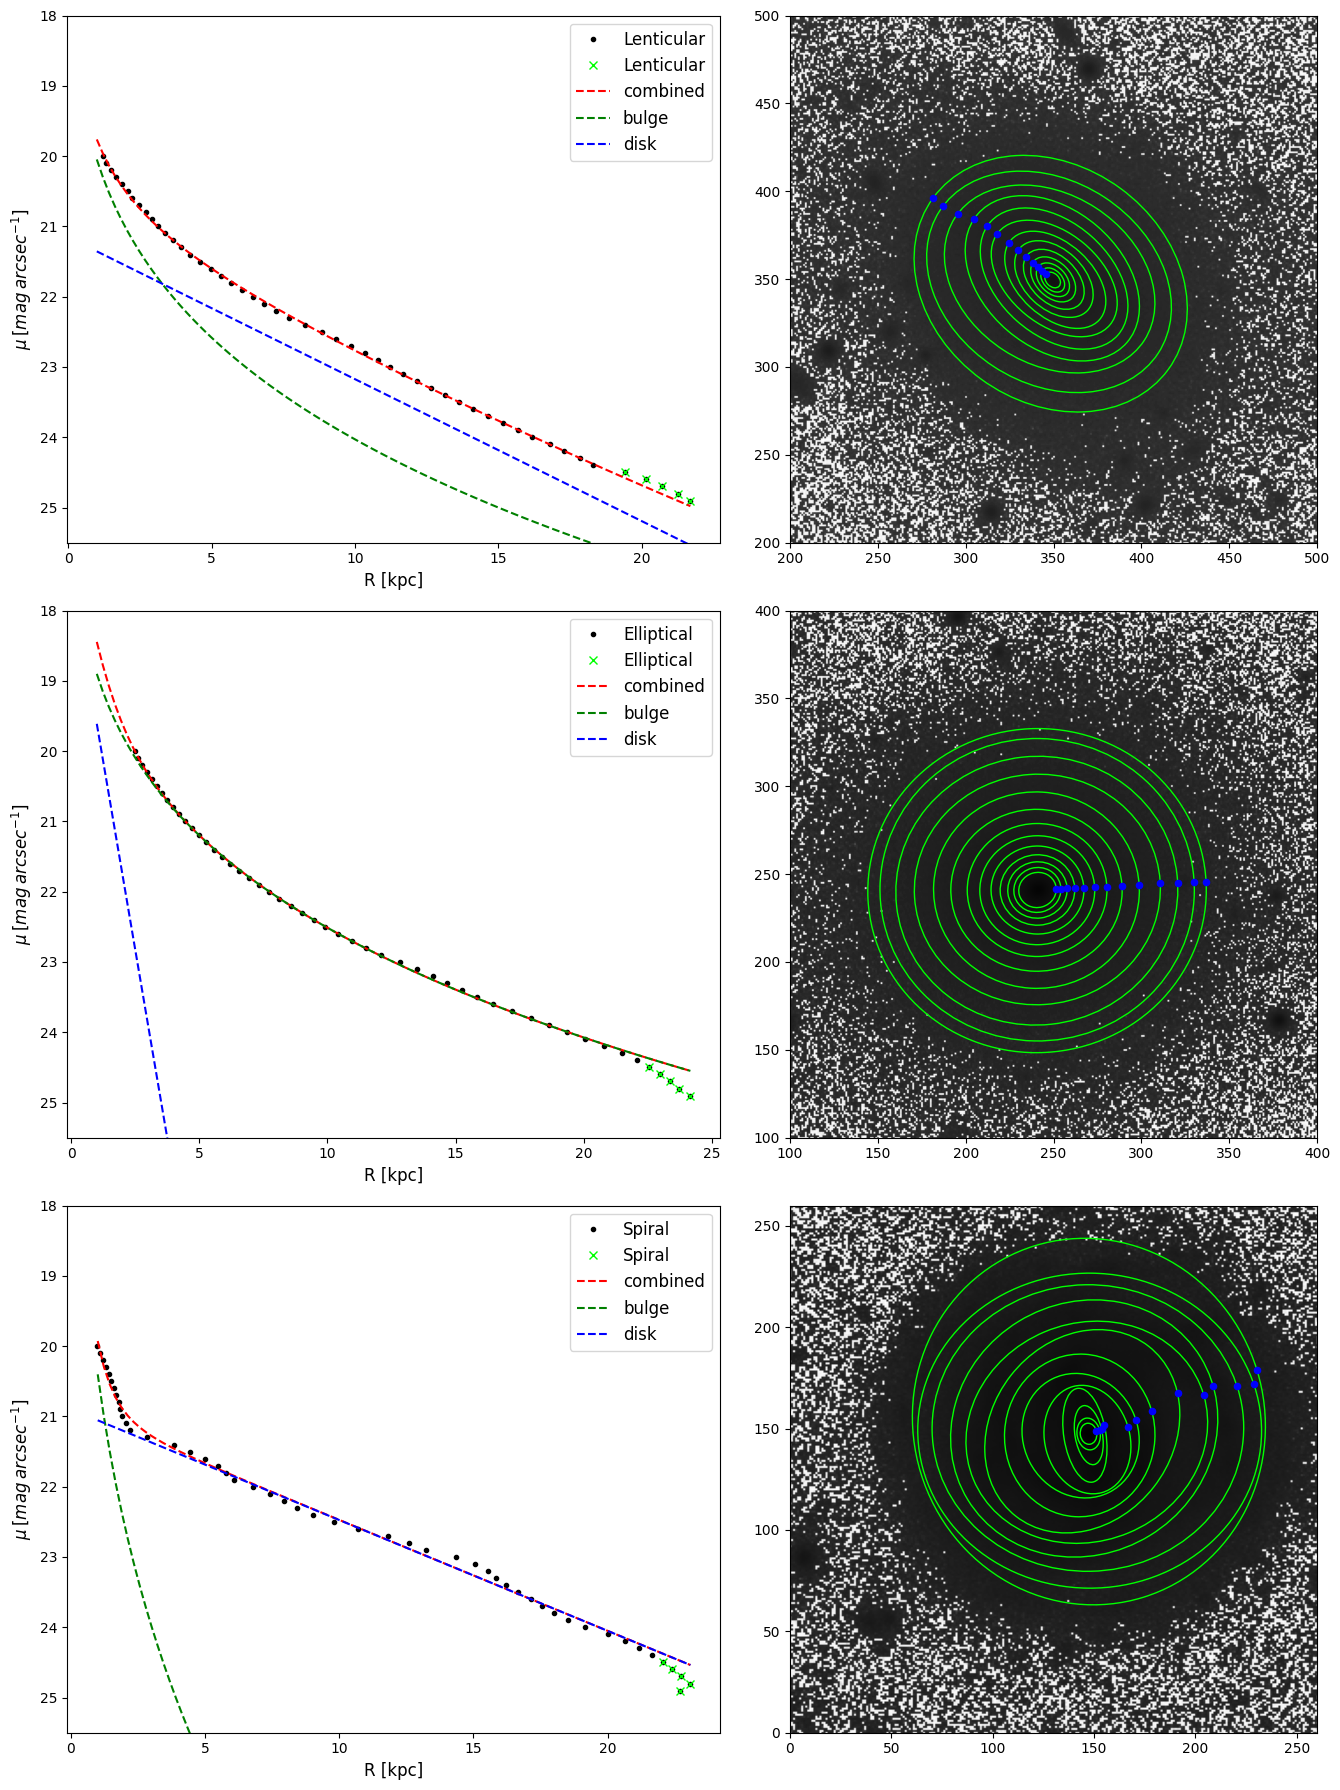

In [46]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 18), dpi=100)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

plot_lc(targ_len, out_len, ax1, 'Lenticular')
plot_lc(targ_ell, out_ell, ax3, 'Elliptical')
plot_lc(targ_spi, out_spi, ax5, 'Spiral')

plot_contours(c_r_len, g_len, [200, 500], ax2, 0)
plot_contours(c_r_ell, g_ell, [100, 400], ax4, 0)
plot_contours(c_r_spi, g_spi, [0, 260], ax6, -np.pi/2)

plt.tight_layout()

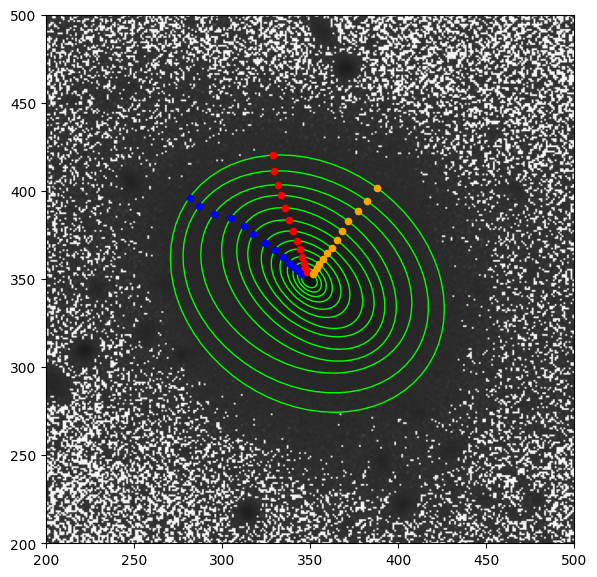

In [30]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
map_ = ax.imshow(g_len.cutout['mag'], cmap='gray')
ax.set_xlim([200, 500])
ax.set_ylim([200, 500])
ang1, ang2, ang3 = 0, -np.pi/4, -np.pi/2
theta_ref = c_r_len[-1][4]
for row_i in c_r_len[::-4]:
    xci, yci, ai, bi, thetai, resi = row_i

    ep1 = ellipse_para(ang1 + (theta_ref - thetai),  xci, yci, ai, bi, thetai)
    ax.scatter(ep1[0], ep1[1], color='blue', s=20, zorder=10)

    ep2 = ellipse_para(ang2 + (theta_ref - thetai),  xci, yci, ai, bi, thetai)
    ax.scatter(ep2[0], ep2[1], color='red', s=20, zorder=10)

    ep3 = ellipse_para(ang3 + (theta_ref - thetai),  xci, yci, ai, bi, thetai)
    ax.scatter(ep3[0], ep3[1], color='orange', s=20, zorder=10)

    ell_patchi = Ellipse((xci, yci), 2*ai, 2*bi, np.rad2deg(thetai), edgecolor='lime', facecolor='none', lw=1)
    ax.add_patch(ell_patchi)

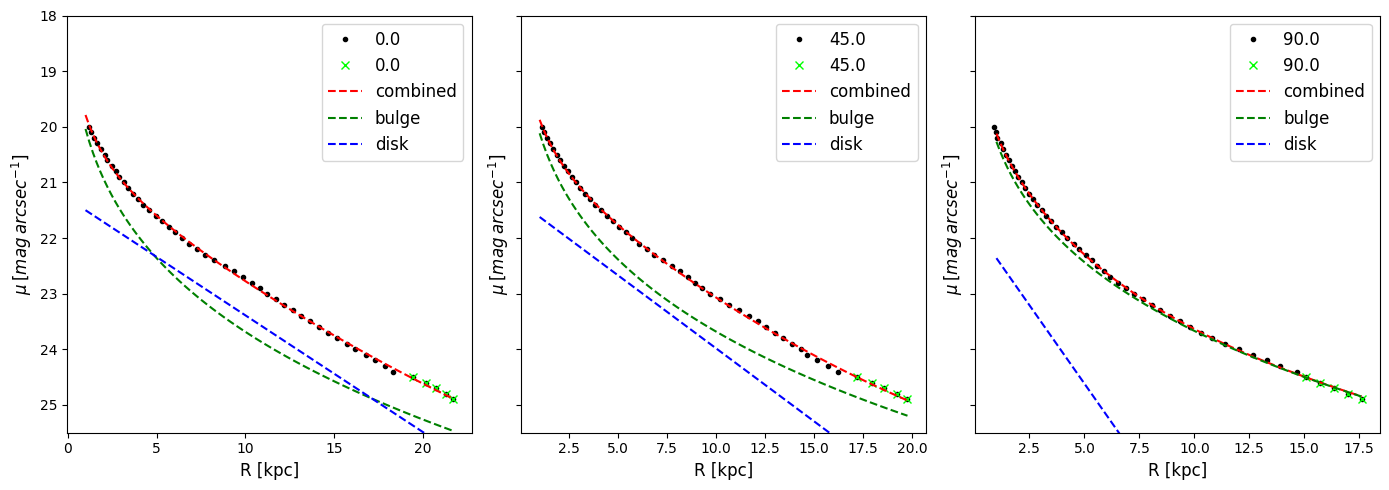

In [47]:
# inc: 56.4, t:-1
targ_len1 = target_angle(ang1, c_r_len)
targ_len2 = target_angle(ang2, c_r_len)
targ_len3 = target_angle(ang3, c_r_len)

out_len1 = curve_fit(combine, targ_len1, mag_r, p0=[19, 20, 30, 30, 4])
out_len2 = curve_fit(combine, targ_len2, mag_r, p0=[19, 20, 30, 30, 4])
out_len3 = curve_fit(combine, targ_len3, mag_r, p0=[19, 20, 30, 30, 4])

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 5), dpi=100, sharey=True)

plot_lc(targ_len1, out_len1, ax1, f'{np.abs(np.rad2deg(ang1))}')
plot_lc(targ_len2, out_len2, ax2, f'{np.abs(np.rad2deg(ang2))}')
plot_lc(targ_len3, out_len3, ax3, f'{np.abs(np.rad2deg(ang3))}')

plt.tight_layout()